In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh";
    from dolfin import *

--2025-04-17 15:41:45--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-04-17 15:41:46 (43.9 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/38ac8c13/releases/pybi

In [ ]:
# Install RBniCS
try:
    import rbnics
except ImportError:
    !pip3 install git+https://github.com/RBniCS/RBniCS.git
    import rbnics
import rbnics.utils.config
assert "dolfin" in rbnics.utils.config.config.get("backends", "required backends")
from rbnics import *

  Cloning https://github.com/RBniCS/RBniCS.git to /tmp/pip-req-build-b6fn3yoz
  Running command git clone --filter=blob:none --quiet https://github.com/RBniCS/RBniCS.git /tmp/pip-req-build-b6fn3yoz
  Resolved https://github.com/RBniCS/RBniCS.git to commit b23d20d68d22579c0995b16025f7f1e858d65259
  Preparing metadata (setup.py) ... done
  Created wheel for RBniCS: filename=RBniCS-0.2.0-py3-none-any.whl size=598339 sha256=3cf454c79c476d4d3dd38538d9ee90ff2551199be5724704ba628516936698bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-72vbymte/wheels/91/6e/53/8e8074380bbeb5ca55786b492fcb71afa192955accca0a7cea
Successfully built RBniCS


# Kirchhof-Love plate

Ahora tenemos una losa cuadrada que dividimos en 4 cuadrantes, numerados de la siguiente forma:


1.   Inferior izquierdo
2.   Inferior derecho
3.   Superior izquierdo
4.   Superior derecho

A cada cuadrante se le aplica una fuerza transversal distinta que es constante en cada cuadrante



In [ ]:
class Kirchhoff_plate(EllipticCoerciveProblem):

    # Inicialización
    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        # Datos de FEniCS
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u, self.w = TrialFunction(M)
        self.v2, self.v1 = TestFunction(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.D = 3.43e5
        self.M = M

    # Nombre del problema
    def name(self):
        return "Kirchhoff_plate"

    # Términos theta para la expansión afín
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1  # Solo un término para la rigidez
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0]*10**4 # q1
            theta_f1 = mu[1]*10**4  # q2
            theta_f2 = mu[2]*10**4  # q3
            theta_f3 = mu[3]*10**4 #q4
            return (theta_f0, theta_f1, theta_f2, theta_f3)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Ensamblaje de operadores
    def assemble_operator(self, term):
        v1 = self.v1
        v2 = self.v2
        dx = self.dx
        D = self.D
        if term == "a":
            u = self.u
            w = self.w
            a0 = u*v1*dx + inner(grad(w),grad(v1))*dx - inner(grad(u),grad(v2))*dx
            return (a0,)
        elif term == "f":
            # Definir carga por tramos
            f0 = v2/D * dx(1) # Primer
            f1 = v2/D * dx(2) # Segundo
            f2 = v2/D * dx(3) # Tercer
            f3 = v2/D * dx(4) # Cuarto
            return (f0, f1, f2, f3)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 2),  # u(1) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 3),  # u(2) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 4),  # u(3) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 1),  # w(0) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 2),  # w(1) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 3),  # w(2) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 4)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            w = self.w
            x0 = inner(u, v2) * dx + inner(grad(u), grad(v2)) * dx + inner(w, v1) * dx + inner(grad(w), grad(v1)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [ ]:

# Parámetros del dominio
Lx, Ly = 50.0, 50.0  # Tamaño del cuadrado
nx, ny = 90, 90    # Número de divisiones de la malla

# Crear la malla del cuadrado
mesh = RectangleMesh(Point(0.0, 0.0), Point(Lx, Ly), nx, ny)

# Crear funciones para subdominios y fronteras
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
subdomains.set_all(0)
boundaries.set_all(0)

# Marcar subcuadrados (2x2): dividimos el cuadrado en 4
for cell in cells(mesh):
    x, y = cell.midpoint().x(), cell.midpoint().y()
    if x <= Lx/2 and y <= Ly/2:
        subdomains[cell] = 1  # abajo izquierda
    elif x > Lx/2 and y <= Ly/2:
        subdomains[cell] = 2  # abajo derecha
    elif x <= Lx/2 and y > Ly/2:
        subdomains[cell] = 3  # arriba izquierda
    else:
        subdomains[cell] = 4  # arriba derecha

# Marcar fronteras
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], Lx)

class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], Ly)

# Instanciar y marcar
left = LeftBoundary()
right = RightBoundary()
bottom = BottomBoundary()
top = TopBoundary()

left.mark(boundaries, 1)
right.mark(boundaries, 2)
bottom.mark(boundaries, 3)
top.mark(boundaries, 4)

# Espacio de elementos finitos mixto
V = FiniteElement("P", mesh.ufl_cell(), 1)
W = FiniteElement("P", mesh.ufl_cell(), 1)
M = FunctionSpace(mesh, MixedElement([V, W]))

In [ ]:
# Crear problema
problem = Kirchhoff_plate(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0), (-10.0, 10.0)]  # Rango de q1, q2, q3, q4
problem.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(10)  # Máximo de funciones en la base
reduction_method.set_tolerance(0.000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_691c42fa0a0817ab48328b90dfa17c0e42843463

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0234392 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_beccab11e9f6487065056dd071b07caea5a09c35

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.017179 seconds.

INFO:FFC:Compiler stage 2: Computin

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_fe702ee8b8a095b0c8245d687ea9623c8ca3cb17

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0195587 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e07ef2c6c0ae105b9df49e53aa61b6c582b1edcb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0183375 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9fd3faffe082930cd65ce18029db198fa827f0f0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 5
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0182061 seconds.

INFO:FFC:Compiler stage 2: Computi

=              Kirchhoff_plate POD-Galerkin offline phase begins               =

###################################### 0 #######################################
truth solve for mu = (5.721134829031378, -8.497471596506877, 5.394546913226314, -1.8956430364102843)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (-2.4665373696219284, 7.472362803238067, -4.989264222270535, -2.521274569207675)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (-2.4918334411883354, 5.350164090974781, 8.459925896866633, -6.090540227072216)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (5.487035127433765, 3.391944379672937, -5.041321228921436, 1.7295347638005225)
update snapshots matrix

###################################### 4 #######################################
truth sol

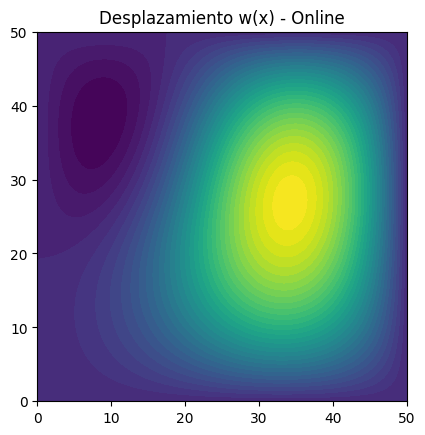

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (-0.1, 0.5, -0.8, 1)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()

# Reconstruir la solución en el espacio completo
full_solution = reduced_problem.basis_functions * reduced_solution  # Producto matricial con las bases
u, w = full_solution.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(w, title="Desplazamiento w(x) - Online")
plt.show()

In [ ]:
print(w(25,25)) #En softare de MEF 111
print(w(10,40)) #En softare de MEF -18.8
print(w(40,10)) #En softare de MEF 74.5
print(w(10,10)) #En softare de MEF 13.6
print(w(40,40)) #En softare de MEF 94

111.03423234980455
-18.79963697199013
75.67030815045192
13.7430872870227
93.67988558939912


## Variando el espesor

Ahora además de variar $q$ en los cuadrantes variamos el espesor. Esto afecta el valor de $D$ en cada cuadrante ya que $D= \frac{e^3E}{12(1-\nu^2)}$ en donde $e$ es el espesor en metros, $E$ representa las caracterísitcas elasticas del material y $\nu$ es el coeficiente de Poison. Luego pdríamos decir $D= e^3B$ en donde $B=\frac{E}{12(1-\nu^2)}=\frac{3*10^{10}}{12(1-0.3^2)}$

Entonces ahora tendríamos 8 parámetros, los 4 primeros para las cargas y los últimos para el espesor

In [ ]:
class Kirchhoff_plate3(EllipticCoerciveProblem):

    # Inicialización
    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        # Datos de FEniCS
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u, self.w = TrialFunction(M)
        self.v2, self.v1 = TestFunction(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.B = 2.747252747e9
        self.M = M

    # Nombre del problema
    def name(self):
        return "Kirchhoff_plate3"

    # Términos theta para la expansión afín
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1  # Solo un término para la rigidez
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0]*10**4/(mu[4]**3)  # q1
            theta_f1 = mu[1]*10**4/(mu[5]**3)  # q2
            theta_f2 = mu[2]*10**4/(mu[6]**3)  # q3
            theta_f3 = mu[3]*10**4/(mu[7]**3)  # q4
            return (theta_f0, theta_f1, theta_f2, theta_f3)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Ensamblaje de operadores
    def assemble_operator(self, term):
        v1 = self.v1
        v2 = self.v2
        dx = self.dx
        B = self.B
        if term == "a":
            u = self.u
            w = self.w
            a0 = u*v1*dx + inner(grad(w),grad(v1))*dx - inner(grad(u),grad(v2))*dx
            return (a0,)
        elif term == "f":
            # Definir carga por tramos
            f0 = v2/B * dx(1) # Primer
            f1 = v2/B * dx(2) # Segundo
            f2 = v2/B * dx(3) # Tercer
            f3 = v2/B * dx(4) # Cuarto
            return (f0, f1, f2, f3)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 2),  # u(1) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 3),  # u(2) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 4),  # u(3) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 1),  # w(0) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 2),  # w(1) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 3),  # w(2) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 4)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            w = self.w
            x0 = inner(u, v2) * dx + inner(grad(u), grad(v2)) * dx + inner(w, v1) * dx + inner(grad(w), grad(v1)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [ ]:
# Parámetros del dominio
Lx, Ly = 50.0, 50.0  # Tamaño del cuadrado
nx, ny = 90, 90    # Número de divisiones de la malla, son nx*ny*2 triangulos

# Crear la malla del cuadrado
mesh = RectangleMesh(Point(0.0, 0.0), Point(Lx, Ly), nx, ny)

# Crear funciones para subdominios y fronteras
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
subdomains.set_all(0)
boundaries.set_all(0)

# Marcar subcuadrados (2x2): dividimos el cuadrado en 4
for cell in cells(mesh):
    x, y = cell.midpoint().x(), cell.midpoint().y()
    if x <= Lx/2 and y <= Ly/2:
        subdomains[cell] = 1  # abajo izquierda
    elif x > Lx/2 and y <= Ly/2:
        subdomains[cell] = 2  # abajo derecha
    elif x <= Lx/2 and y > Ly/2:
        subdomains[cell] = 3  # arriba izquierda
    else:
        subdomains[cell] = 4  # arriba derecha

# Marcar fronteras
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], Lx)

class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], Ly)

# Instanciar y marcar
left = LeftBoundary()
right = RightBoundary()
bottom = BottomBoundary()
top = TopBoundary()

left.mark(boundaries, 1)
right.mark(boundaries, 2)
bottom.mark(boundaries, 3)
top.mark(boundaries, 4)

# Espacio de elementos finitos mixto
V = FiniteElement("P", mesh.ufl_cell(), 1)
W = FiniteElement("P", mesh.ufl_cell(), 1)
M = FunctionSpace(mesh, MixedElement([V, W]))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_022704741ebac5cb750a821aa28214a1b9170095

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00368071 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.399163 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00236487 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00906658 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

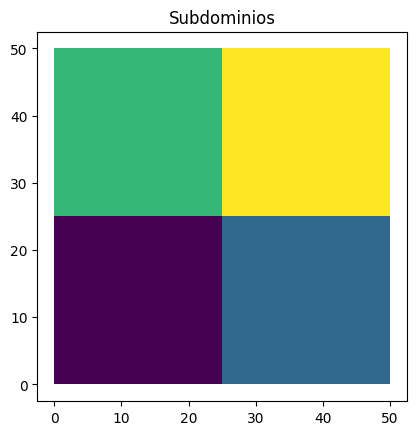

In [ ]:
plot(subdomains, title="Subdominios")
plt.show()

In [ ]:
# Crear problema
problem2 = Kirchhoff_plate3(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10,10) for i in range(4)] + [(0.04,0.6) for i in range(4)] # Rango de q1, q2, q3, q4
problem2.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method2 = PODGalerkin(problem2)
reduction_method2.set_Nmax(15)  # Máximo de funciones en la base
reduction_method2.set_tolerance(0.0000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method2.initialize_training_set(100)
reduced_problem2 = reduction_method2.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b163dac18b41582c754ff33991cac2680b47955d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0858588 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c8200760ff7ba9a9e86a2b7f8555ff38fb61d8ec

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00218964 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00818515 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3142d14591a69ae8a843853a55af6e9149fc9f3e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00375986 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0274577 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_02408bfcd9b1979fed57bdec2d29753994b7e4c5

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00243115 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.012048 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_5dfbb7d6385c0bc8c968e61fc70db68456ade8e7

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00318527 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0148995 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7baaa2633b517536f4839218622dd573ce4759c2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0386431 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6a1a83533347abcd952b7c8d7ec7b5774ef9ae7d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.041193 seconds.

INFO:FFC:Compiler stage 2: Computin

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9e3ebaaaf474d0ae7065238e1d7ea0c9b01f7797

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0623357 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7598a2b92543e938c6672631e0b3730da092afd8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 5
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0267103 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ae8599740e88bfeec09392c34851d39f80fee4d7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0333898 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ca26299b2b11f979027d9b758f4afeca0bfaf22a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0154774 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_88909014e5429e2578d338a011ffd956bc5c7cb7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_43]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0207093 seconds.

INFO:FFC:Compiler stage 2:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_57b2d046702a951357e83418ce8e636842a8edc4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00206852 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00937104 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

=              Kirchhoff_plate3 POD-Galerkin offline phase begins              =

###################################### 0 #######################################
truth solve for mu = (0.8399823564764262, -6.3656808384599595, -2.264987735225903, -3.534342958938341, 0.4424506144064614, 0.5852736680571489, 0.18479080581033022, 0.22113873918853955)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (-4.918058920830131, 9.812422177559132, -3.7669825551625475, -7.487330804603747, 0.31710705047933674, 0.3126385542282959, 0.2631249577798564, 0.5800490963547305)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (0.6559777596519449, -9.173668241990278, -8.673649132026295, 3.575516350924378, 0.11538474792176182, 0.15608524037408475, 0.5083916038577623, 0.300747237572025)
update snapshots matrix

###################################### 3 #########

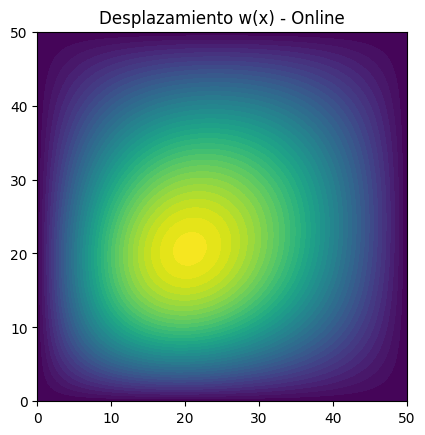

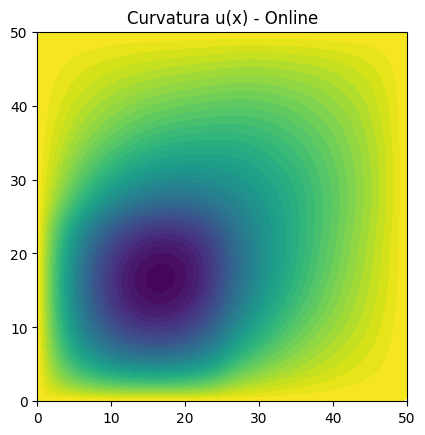

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (5, 5, 5, 5, 0.05, 0.3, 0.5, 0.1)
reduced_problem2.set_mu(online_mu)
reduced_solution2 = reduced_problem2.solve()

# Reconstruir la solución en el espacio completo
full_solution2 = reduced_problem2.basis_functions * reduced_solution2  # Producto matricial con las bases
u, w = full_solution2.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(w, title="Desplazamiento w(x) - Online")
plt.show()
plot(u, title="Curvatura u(x) - Online")
plt.show()

In [ ]:
print(w(10,40))
print(w(20,20))

326.93899878403465
1121.2148359898872


In [ ]:
print(reduced_solution2.vector())

[2315.95066272 -596.00869372  222.61581716   83.8590056 ]


In [ ]:
import pandas as pd
import random
import numpy as np

# Generar 20 puntos aleatorios en el dominio [0,1] x [0,1]
np.random.seed(42)  # Para reproducibilidad
n_points = 20
points_x = np.random.uniform(0, 50, n_points)
points_y = np.random.uniform(0, 50, n_points)

# Evaluar w en los puntos aleatorios
w_values = []
for x, y in zip(points_x, points_y):
    point = Point(x, y)
    try:
        w_val = w(point)  # Evaluar w en el punto
        w_values.append(w_val)
    except:
        w_values.append(0.0)  # En caso de error (fuera del dominio o singularidad)

# Crear un DataFrame con las coordenadas y valores
data = {
    "coordenada x": points_x,
    "coordenada y": points_y,
    "valor de w": w_values
}
df = pd.DataFrame(data)

# Exportar a Excel
output_file = "w_values.xlsx"
df.to_excel(output_file, index=False)
print(f"Datos exportados a {output_file}")

Datos exportados a w_values.xlsx


In [ ]:
# Descargar el archivo en Colab
from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Observaciones

Vemos que al variar el espesor de los cuadrantes el modelo anda mal. Revisando varias opciones llegamos a la conclusión que lo más probable es que el problema este en que $\Delta w$ no tiene por qué ser continuo en la frontera de los cuadrantes. Esto generaría problemas ya que al hacer el cambio de variable también estamos forzando a que $u=\Delta w$ sea continuo.

**Opción 1**

Buscar otra forma de resolver el problema sin usar cambio de variable ya sea con penalización (no la pude hacer andar) o nodos de Hermite

**Opción 2**

Realizar el cambio de variable $\nabla w = u$ en vez. De esta forma $\Delta w$ no tiene que ser continua y se pueden poner condiciones de borde sobre este imponiendo condiciones sobre la derivada de $u$ en el borde. Quedaría algo de esta forma:

$
\left\{
\begin{align}
u &= \nabla w \\
\Delta div( u)  &= \frac{q}{D}
\end{align}
\right.
$

Con condiciones de borde $w=0$ y $div(u)=0$ en $\partial\Omega$

Esto porque $\Delta w = div(\nabla w)$ entonces $\Delta^2 w = \Delta div(\nabla w) = \Delta div(u)$

La formulación débil creo que quedaría algo así

$\int_\Omega (\Delta div(u))v=\int_\Omega \frac{q}{D}v$

En el primer término, llamo $z=div(u)$ y luego hacemos partes

$\int_\Omega (\Delta div(u))v= \int_\Omega (\Delta z)v = \int_{\partial\Omega} (\nabla z·n)v-\int_\Omega \nabla z · \nabla v$

Como $v=0$ en $\partial\Omega$ entonces $\int_{\partial\Omega} (\nabla z·n)v=0$
Luego deshaciendo el cambio de variable

$\int_\Omega (\Delta div(u))v= -\int_\Omega \nabla z · \nabla v = -\int_\Omega (\Delta u)\nabla v$

Y por lo tanto la formulación débil quedaría $-\int_\Omega (\Delta u)\nabla v = \int_\Omega \frac{q}{D}v$

**Opción 3**

Aumento la cantidad de campos y defino un campo $w$ (desplazamientos) y un campo $u$ (curvatura o laplaciano) para cada cuadrante (subdominio). Luego establecemos condiciones de borde distintas teniendo en cuenta que los deplazamientos son iguales en las fornteras y las curvaturas deben cumplir $w^1_{xx}·e_1^3 = w^2_{xx}·e_2^3$ y $w^1_{yy}=w^2_{yy}$ si la frontera es vertical y
$w^1_{yy}·e_1^3 = w^2_{yy}·e_2^3$ y $w^1_{xx}=w^2_{xx}$ si la frontera es horizontal.

¿Cómo repercute esto en los $u$ si $u=w_{xx}+w_{yy}$?

# Variando espesor igual en todas las secciones

Ahora agregamos un solo parametro para el espesor que afecta a todas las secciones

In [ ]:
class Kirchhoff_plate3(EllipticCoerciveProblem):

    # Inicialización
    def __init__(self, M, **kwargs):
        EllipticCoerciveProblem.__init__(self, M, **kwargs)
        # Datos de FEniCS
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u, self.w = TrialFunction(M)
        self.v2, self.v1 = TestFunction(M)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Propiedades físicas
        self.B = 2.747252747e9
        self.M = M

    # Nombre del problema
    def name(self):
        return "Kirchhoff_plate3"

    # Términos theta para la expansión afín
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1  # Solo un término para la rigidez
            return (theta_a0,)
        elif term == "f":
            theta_f0 = mu[0]*10**4/(mu[4]**3)  # q1
            theta_f1 = mu[1]*10**4/(mu[4]**3)  # q2
            theta_f2 = mu[2]*10**4/(mu[4]**3)  # q3
            theta_f3 = mu[3]*10**4/(mu[4]**3)  # q4
            return (theta_f0, theta_f1, theta_f2, theta_f3)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Ensamblaje de operadores
    def assemble_operator(self, term):
        v1 = self.v1
        v2 = self.v2
        dx = self.dx
        B = self.B
        if term == "a":
            u = self.u
            w = self.w
            a0 = u*v1*dx + inner(grad(w),grad(v1))*dx - inner(grad(u),grad(v2))*dx
            return (a0,)
        elif term == "f":
            # Definir carga por tramos
            f0 = v2/B * dx(1) # Primer
            f1 = v2/B * dx(2) # Segundo
            f2 = v2/B * dx(3) # Tercer
            f3 = v2/B * dx(4) # Cuarto
            return (f0, f1, f2, f3)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 1),  # u(0) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 2),  # u(1) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 3),  # u(2) = 0
                   DirichletBC(self.M.sub(0), Constant(0.0), self.boundaries, 4),  # u(3) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 1),  # w(0) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 2),  # w(1) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 3),  # w(2) = 0
                   DirichletBC(self.M.sub(1), Constant(0.0), self.boundaries, 4)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            w = self.w
            x0 = inner(u, v2) * dx + inner(grad(u), grad(v2)) * dx + inner(w, v1) * dx + inner(grad(w), grad(v1)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [ ]:
# Parámetros del dominio
Lx, Ly = 50.0, 50.0  # Tamaño del cuadrado
nx, ny = 90, 90    # Número de divisiones de la malla, son nx*ny*2 triangulos

# Crear la malla del cuadrado
mesh = RectangleMesh(Point(0.0, 0.0), Point(Lx, Ly), nx, ny)

# Crear funciones para subdominios y fronteras
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
subdomains.set_all(0)
boundaries.set_all(0)

# Marcar subcuadrados (2x2): dividimos el cuadrado en 4
for cell in cells(mesh):
    x, y = cell.midpoint().x(), cell.midpoint().y()
    if x <= Lx/2 and y <= Ly/2:
        subdomains[cell] = 1  # abajo izquierda
    elif x > Lx/2 and y <= Ly/2:
        subdomains[cell] = 2  # abajo derecha
    elif x <= Lx/2 and y > Ly/2:
        subdomains[cell] = 3  # arriba izquierda
    else:
        subdomains[cell] = 4  # arriba derecha

# Marcar fronteras
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], Lx)

class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], Ly)

# Instanciar y marcar
left = LeftBoundary()
right = RightBoundary()
bottom = BottomBoundary()
top = TopBoundary()

left.mark(boundaries, 1)
right.mark(boundaries, 2)
bottom.mark(boundaries, 3)
top.mark(boundaries, 4)

# Espacio de elementos finitos mixto
V = FiniteElement("P", mesh.ufl_cell(), 1)
W = FiniteElement("P", mesh.ufl_cell(), 1)
M = FunctionSpace(mesh, MixedElement([V, W]))

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_022704741ebac5cb750a821aa28214a1b9170095

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00233769 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.250917 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0018394 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00762939 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [ ]:
# Crear problema
problem2 = Kirchhoff_plate3(M, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-10,10) for i in range(4)] + [(0.04,0.6)] # Rango de q1, q2, q3, q4 y el espesor
problem2.set_mu_range(mu_range)

In [ ]:
# Etapa Offline: Método de reducción POD-Galerkin
reduction_method2 = PODGalerkin(problem2)
reduction_method2.set_Nmax(15)  # Máximo de funciones en la base
reduction_method2.set_tolerance(0.0000001)  # Tolerancia

# Generar conjunto de entrenamiento
reduction_method2.initialize_training_set(100)
reduced_problem2 = reduction_method2.offline()
print("Etapa offline completada.")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_691c42fa0a0817ab48328b90dfa17c0e42843463

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.056525 seconds.

INFO:FFC:Compiler stage 2: Com

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c8200760ff7ba9a9e86a2b7f8555ff38fb61d8ec

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00327349 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0115323 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3142d14591a69ae8a843853a55af6e9149fc9f3e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00326538 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0124214 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_02408bfcd9b1979fed57bdec2d29753994b7e4c5

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00812006 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0143371 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_5dfbb7d6385c0bc8c968e61fc70db68456ade8e7

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0033865 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00890088 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e57f86a04e21445aab19cfdd4c8c812f3165093e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0183878 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_054e6793878bcb9953bfaef02a66205cfb0f0d5c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 3
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0139446 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a29d12b33cfc13986ccb4c4a3eba8a22b3bcf140

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 4
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0197124 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_dc37b0563973abfd62fb8f9695b5eef11d21a01f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 5
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0187116 seconds.

INFO:FFC:Compiler stage 2: Computi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ae8599740e88bfeec09392c34851d39f80fee4d7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG1(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0215883 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ca26299b2b11f979027d9b758f4afeca0bfaf22a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.014977 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_88909014e5429e2578d338a011ffd956bc5c7cb7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_46]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0231855 seconds.

INFO:FFC:Compiler stage 2:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_57b2d046702a951357e83418ce8e636842a8edc4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00166488 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00764561 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

=              Kirchhoff_plate3 POD-Galerkin offline phase begins              =

###################################### 0 #######################################
truth solve for mu = (1.0013606317865182, -0.5266075726452044, 5.287276118780333, -8.782020233848268, 0.5072379567722773)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (3.8289138888164267, 4.761876754252599, -0.07203075717694851, -2.7579640239186816, 0.43782584343997716)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (7.456459711443216, 8.850342084927064, -3.115113937708454, -9.975331259698798, 0.5074984422865533)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (4.537681574163736, 0.6549057173205988, 3.4397539498811653, 9.143885765043517, 0.5934651237918044)
update snapshots matrix

#######

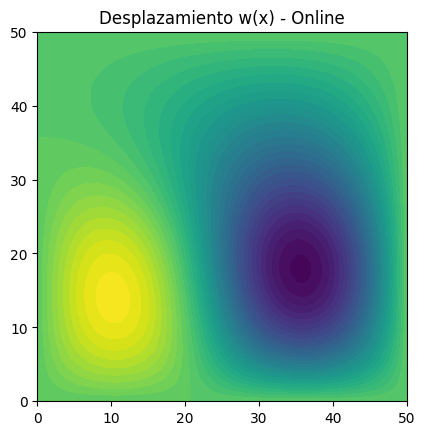

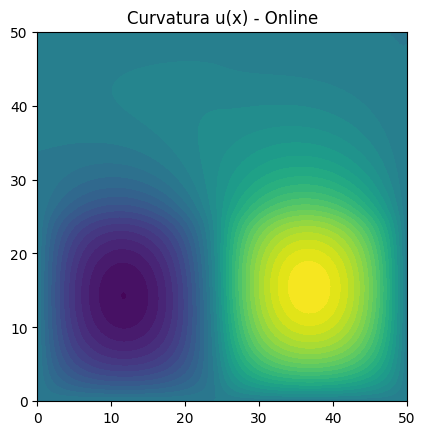

In [ ]:
# Etapa Online: Resolver para nuevos parámetros
online_mu = (4, -5, -0.5, 0.2, 0.3)
reduced_problem2.set_mu(online_mu)
reduced_solution2 = reduced_problem2.solve()

# Reconstruir la solución en el espacio completo
full_solution2 = reduced_problem2.basis_functions * reduced_solution2  # Producto matricial con las bases
u, w = full_solution2.split()  # Ahora sí podemos dividir

# Visualización
import matplotlib.pyplot as plt
plt.figure()
plot(w, title="Desplazamiento w(x) - Online")
plt.show()
plot(u, title="Curvatura u(x) - Online")
plt.show()

In [ ]:
print(w(25,25)) #En softare de MEF 1.115
print(w(10,40)) #En softare de MEF -0.13
print(w(40,10)) #En softare de MEF -1.64
print(w(10,10)) #En softare de MEF 0.70
print(w(40,40)) #En softare de MEF -0.58

-1.1103881045229649
-0.1272380984855891
-1.639387020219969
0.6996206291621232
-0.5773161634976149


## Comparación

Resultados: dan bien ambos

Tiempo:

softare de MEF: 10.12s

 RBniCS: menos de 1s